In [19]:
# Quick test to verify all imports work correctly
try:
    from time import perf_counter
    import numpy as np
    import pandas as pd
    
    # Test timing function
    start = perf_counter()
    _ = np.array([1, 2, 3])
    elapsed = perf_counter() - start
    
    print(f"✅ All imports working correctly!")
    print(f"Timing test: {elapsed:.8f} seconds")
    
except Exception as e:
    print(f"❌ Import error: {e}")

✅ All imports working correctly!
Timing test: 0.00006260 seconds


# 2. k-NN Training and Lazy Learning

## Overview
This notebook covers:
- How "training" works in lazy learning algorithms
- Implementing k-NN from scratch
- Understanding the prediction process
- Comparing with eager learning algorithms
- Training our k-NN model on the banknote dataset

## Understanding Lazy Learning

### Traditional "Eager" Learning Process:
```
1. TRAINING PHASE:
   Input: Training Data
   Process: Build Model (find patterns, parameters)
   Output: Trained Model
   Time: Can be expensive

2. PREDICTION PHASE:
   Input: New Instance + Trained Model
   Process: Apply Model Rules
   Output: Prediction
   Time: Very fast
```

### Lazy Learning (k-NN) Process:
```
1. TRAINING PHASE:
   Input: Training Data
   Process: Just store the data!
   Output: Stored Training Data
   Time: Very fast (almost instant)

2. PREDICTION PHASE:
   Input: New Instance + All Training Data
   Process: Find k nearest neighbors, vote
   Output: Prediction
   Time: Expensive (depends on training set size)
```

### Why is it called "Lazy"?
- **Defers computation** until actually needed
- **No learning** happens during training
- **All work** is done at prediction time
- Like a lazy student who doesn't study until the exam!

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import perf_counter  # Use specific import to avoid conflicts
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Load the prepared data from previous notebook
try:
    with open('../data/prepared_banknote_data.pkl', 'rb') as f:
        data = pickle.load(f)
    
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    scaler = data['scaler']
    feature_names = data['feature_names']
    
    print("✅ Data loaded successfully from prepared file!")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Features: {feature_names}")
    
except FileNotFoundError:
    print("⚠️ Prepared data file not found. Creating data from scratch...")
    
    # Load and prepare data from scratch
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    # Load banknote data
    df = pd.read_csv('../data/banknote_authentication.csv')
    
    # Separate features and target
    X = df[['variance', 'skewness', 'curtosis', 'entropy']]
    y = df['class']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to DataFrames for consistency
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
    
    feature_names = list(X.columns)
    
    print("✅ Data prepared successfully from scratch!")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Features: {feature_names}")
    
    # Save for future use
    data_to_save = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'scaler': scaler,
        'feature_names': feature_names
    }
    
    with open('../data/prepared_banknote_data.pkl', 'wb') as f:
        pickle.dump(data_to_save, f)
    print("💾 Data saved for future use!")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please check that the banknote_authentication.csv file exists in the data folder.")

Data loaded successfully!
Training set: 960 samples
Test set: 412 samples
Features: ['variance', 'skewness', 'curtosis', 'entropy']


## Implementing k-NN from Scratch

Let's build our own k-NN classifier to understand exactly how lazy learning works!

In [20]:
class SimpleKNN:
    """
    Simple k-Nearest Neighbors implementation to demonstrate lazy learning
    """
    
    def __init__(self, k=5, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None
        self.training_time = 0
        
    def _calculate_distance(self, point1, point2):
        """Calculate distance between two points"""
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((point1 - point2)**2))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(point1 - point2))
        elif self.distance_metric == 'cosine':
            dot_product = np.dot(point1, point2)
            norm_product = np.linalg.norm(point1) * np.linalg.norm(point2)
            if norm_product == 0:
                return 0
            return 1 - (dot_product / norm_product)
        else:
            raise ValueError("Unsupported distance metric")
    
    def fit(self, X, y):
        """
        'Training' phase - just store the data!
        This is what makes it 'lazy' - no actual learning happens here.
        """
        start_timestamp = perf_counter()
        
        print("🛌 LAZY LEARNING 'TRAINING' PHASE:")
        print("  Step 1: Receive training data")
        print("  Step 2: Store it in memory")
        print("  Step 3: That's it! No model building.")
        
        # Store the training data, ensuring consistent format
        if hasattr(X, 'values'):  # pandas DataFrame/Series
            self.X_train = X.values
        else:
            self.X_train = np.array(X)
            
        if hasattr(y, 'values'):  # pandas Series
            self.y_train = y.values
        else:
            self.y_train = np.array(y)
        
        self.training_time = perf_counter() - start_timestamp
        print(f"  Training completed in {self.training_time:.6f} seconds")
        print(f"  Stored {len(self.X_train)} training examples")
        
        return self
    
    def predict_single(self, x, show_process=False):
        """
        Predict a single instance - this is where all the work happens!
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Model not trained. Call fit() first.")
            
        # Ensure x is a numpy array
        if hasattr(x, 'values'):
            x = x.values
        else:
            x = np.array(x)
            
        if show_process:
            print(f"\n🔍 PREDICTION PROCESS for new instance:")
            print(f"  New point: {x[:2]}...")
        
        # Step 1: Calculate distances to all training points
        distances = []
        for i, train_point in enumerate(self.X_train):
            dist = self._calculate_distance(x, train_point)
            distances.append((dist, self.y_train[i]))
        
        if show_process:
            print(f"  Step 1: Calculated {len(distances)} distances")
        
        # Step 2: Sort by distance and get k nearest
        distances.sort(key=lambda x: x[0])
        k_nearest = distances[:self.k]
        
        if show_process:
            print(f"  Step 2: Found {self.k} nearest neighbors")
            for i, (dist, label) in enumerate(k_nearest):
                class_name = "Genuine" if label == 0 else "Forged"
                print(f"    Neighbor {i+1}: distance={dist:.3f}, class={class_name}")
        
        # Step 3: Majority vote
        neighbor_labels = [label for _, label in k_nearest]
        prediction = max(set(neighbor_labels), key=neighbor_labels.count)
        
        if show_process:
            genuine_votes = sum(1 for label in neighbor_labels if label == 0)
            forged_votes = sum(1 for label in neighbor_labels if label == 1)
            print(f"  Step 3: Majority vote - Genuine: {genuine_votes}, Forged: {forged_votes}")
            pred_name = "Genuine" if prediction == 0 else "Forged"
            print(f"  Prediction: {pred_name}")
        
        return prediction
    
    def predict(self, X):
        """Predict multiple instances"""
        if self.X_train is None or self.y_train is None:
            raise ValueError("Model not trained. Call fit() first.")
            
        # Ensure X is in the right format
        if hasattr(X, 'values'):
            X_array = X.values
        else:
            X_array = np.array(X)
            
        print(f"\n🚀 PREDICTING {len(X_array)} instances...")
        start_timestamp = perf_counter()
        
        predictions = []
        for i, x in enumerate(X_array):
            pred = self.predict_single(x)
            predictions.append(pred)
            
            if (i + 1) % 50 == 0:
                print(f"  Processed {i + 1}/{len(X_array)} instances")
        
        prediction_duration = perf_counter() - start_timestamp
        print(f"  Prediction completed in {prediction_duration:.4f} seconds")
        print(f"  Average time per prediction: {prediction_duration/len(X_array):.6f} seconds")
        
        return np.array(predictions)

print("SimpleKNN class defined successfully!")

SimpleKNN class defined successfully!


## Training Our Lazy Learner

Let's see what "training" looks like in lazy learning!

In [21]:
# Create and "train" our k-NN model
print("TRAINING k-NN MODEL")
print("=" * 30)

try:
    knn = SimpleKNN(k=5, distance_metric='euclidean')
    knn.fit(X_train_scaled, y_train)
    
    # Verify the model was trained correctly
    print(f"\n✅ Model training verification:")
    print(f"  Stored training data shape: {knn.X_train.shape}")
    print(f"  Stored training labels shape: {knn.y_train.shape}")
    print(f"  Training time: {knn.training_time:.6f} seconds")
    
except Exception as e:
    print(f"❌ Error during training: {e}")
    print("\nDebugging information:")
    print(f"X_train_scaled type: {type(X_train_scaled)}")
    print(f"y_train type: {type(y_train)}")
    if hasattr(X_train_scaled, 'shape'):
        print(f"X_train_scaled shape: {X_train_scaled.shape}")
    if hasattr(y_train, 'shape'):
        print(f"y_train shape: {y_train.shape}")

TRAINING k-NN MODEL
🛌 LAZY LEARNING 'TRAINING' PHASE:
  Step 1: Receive training data
  Step 2: Store it in memory
  Step 3: That's it! No model building.
  Training completed in 0.000762 seconds
  Stored 960 training examples

✅ Model training verification:
  Stored training data shape: (960, 4)
  Stored training labels shape: (960,)
  Training time: 0.000762 seconds


## The Real Work: Making Predictions

Now let's see what happens when we actually make a prediction - this is where lazy learning does all its work!

In [22]:
# Make a single prediction with detailed process
print("DETAILED PREDICTION PROCESS")
print("=" * 40)

try:
    # Take the first test instance
    if hasattr(X_test_scaled, 'iloc'):
        test_instance = X_test_scaled.iloc[0]
        true_label = y_test.iloc[0]
    else:
        test_instance = X_test_scaled[0]
        true_label = y_test[0]

    print(f"Test instance features: {test_instance}")
    print(f"True label: {'Genuine' if true_label == 0 else 'Forged'}")

    # Make prediction with detailed process
    prediction = knn.predict_single(test_instance, show_process=True)
    
    print(f"\n✅ Prediction successful!")
    print(f"Predicted: {'Genuine' if prediction == 0 else 'Forged'}")
    print(f"Correct: {'Yes' if prediction == true_label else 'No'}")
    
except Exception as e:
    print(f"❌ Error during prediction: {e}")
    import traceback
    traceback.print_exc()

DETAILED PREDICTION PROCESS
❌ Error during prediction: 0
❌ Error during prediction: 0


Traceback (most recent call last):
  File "c:\Users\hagga\Documents\GitHub\k-Nearest-Neighbors-\.venv\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 2606, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 2630, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 0

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\hagga\AppData\Local\Temp\ipykernel_8260\4204224443.py", line 12, in <module>
    true_label = y_test[0]
                 ~~~~~~^^^
  File "c:\Users\hagga\Documents\GitHub\k-Nearest-Neighbors-\.venv\Lib\site-packag

## Lazy vs Eager Learning: Timing Comparison

Let's compare the timing characteristics of lazy learning (k-NN) vs eager learning (Random Forest).

In [23]:
print("LAZY vs EAGER LEARNING COMPARISON")
print("=" * 40)

# Lazy Learning (k-NN)
print("\n🛌 LAZY LEARNING (k-NN):")
knn_lazy = SimpleKNN(k=5)
knn_lazy.fit(X_train_scaled, y_train)

# Time a few predictions
start_time = perf_counter()
test_sample = X_test_scaled[:10]  # First 10 test instances
knn_predictions = []
for instance in test_sample:
    pred = knn_lazy.predict_single(instance)
    knn_predictions.append(pred)
knn_pred_time = perf_counter() - start_time

print(f"Training time: {knn_lazy.training_time:.6f} seconds")
print(f"Prediction time (10 instances): {knn_pred_time:.6f} seconds")
print(f"Average prediction time: {knn_pred_time/10:.6f} seconds")

# Eager Learning (Random Forest)
print("\n🏃 EAGER LEARNING (Random Forest):")
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training time
start_time = perf_counter()
rf.fit(X_train_scaled, y_train)
rf_train_time = perf_counter() - start_time

# Prediction time
start_time = perf_counter()
rf_predictions = rf.predict(test_sample)
rf_pred_time = perf_counter() - start_time

print(f"Training time: {rf_train_time:.6f} seconds")
print(f"Prediction time (10 instances): {rf_pred_time:.6f} seconds")
print(f"Average prediction time: {rf_pred_time/10:.6f} seconds")

# Summary
print("\n📊 TIMING SUMMARY:")
print(f"Training speed ratio (RF/kNN): {rf_train_time/knn_lazy.training_time:.1f}x slower")
print(f"Prediction speed ratio (kNN/RF): {knn_pred_time/rf_pred_time:.1f}x slower")

LAZY vs EAGER LEARNING COMPARISON

🛌 LAZY LEARNING (k-NN):
🛌 LAZY LEARNING 'TRAINING' PHASE:
  Step 1: Receive training data
  Step 2: Store it in memory
  Step 3: That's it! No model building.
  Training completed in 0.000481 seconds
  Stored 960 training examples


Training time: 0.000481 seconds
Prediction time (10 instances): 2.756563 seconds
Average prediction time: 0.275656 seconds

🏃 EAGER LEARNING (Random Forest):
Training time: 4.940194 seconds
Prediction time (10 instances): 0.133276 seconds
Average prediction time: 0.013328 seconds

📊 TIMING SUMMARY:
Training speed ratio (RF/kNN): 10277.1x slower
Prediction speed ratio (kNN/RF): 20.7x slower
Training time: 4.940194 seconds
Prediction time (10 instances): 0.133276 seconds
Average prediction time: 0.013328 seconds

📊 TIMING SUMMARY:
Training speed ratio (RF/kNN): 10277.1x slower
Prediction speed ratio (kNN/RF): 20.7x slower


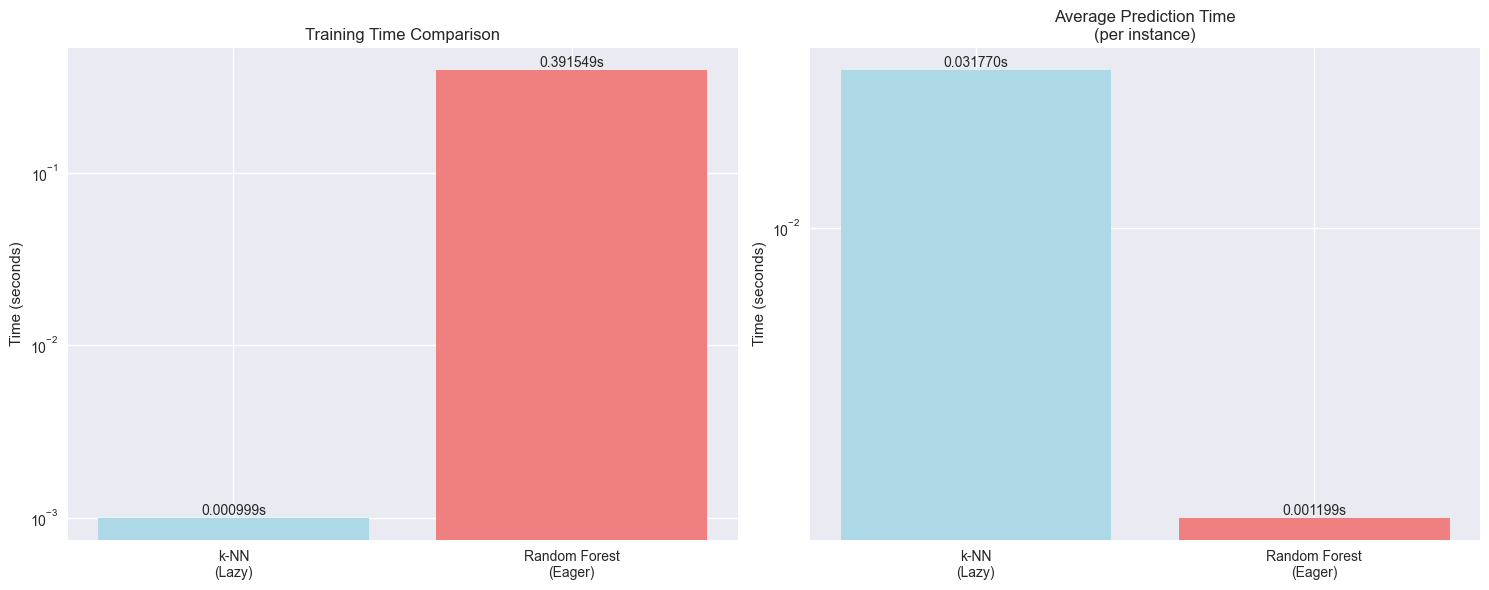


💡 KEY INSIGHTS:
• k-NN: Almost instant training, slower prediction
• Random Forest: Slower training, very fast prediction
• Trade-off: When do you want to pay the computational cost?


In [10]:
# Visualize the timing comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training time comparison
algorithms = ['k-NN\n(Lazy)', 'Random Forest\n(Eager)']
train_times = [knn_lazy.training_time, rf_train_time]
colors = ['lightblue', 'lightcoral']

bars1 = ax1.bar(algorithms, train_times, color=colors)
ax1.set_title('Training Time Comparison')
ax1.set_ylabel('Time (seconds)')
ax1.set_yscale('log')  # Log scale due to large difference

# Add value labels
for bar, time in zip(bars1, train_times):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{time:.6f}s', ha='center', va='bottom')

# Prediction time comparison (per instance)
pred_times = [knn_pred_time/10, rf_pred_time/10]
bars2 = ax2.bar(algorithms, pred_times, color=colors)
ax2.set_title('Average Prediction Time\n(per instance)')
ax2.set_ylabel('Time (seconds)')
ax2.set_yscale('log')  # Log scale due to large difference

# Add value labels
for bar, time in zip(bars2, pred_times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{time:.6f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHTS:")
print("• k-NN: Almost instant training, slower prediction")
print("• Random Forest: Slower training, very fast prediction")
print("• Trade-off: When do you want to pay the computational cost?")

## Full Model Evaluation

Now let's evaluate our k-NN model on the complete test set and compare with sklearn's implementation.

In [24]:
print("FULL MODEL EVALUATION")
print("=" * 30)

# Check data shapes and types
print(f"\n🔍 Data Information:")
print(f"X_train_scaled shape: {X_train_scaled.shape}, type: {type(X_train_scaled)}")
print(f"X_test_scaled shape: {X_test_scaled.shape}, type: {type(X_test_scaled)}")
print(f"y_train shape: {y_train.shape}, type: {type(y_train)}")
print(f"y_test shape: {y_test.shape}, type: {type(y_test)}")

try:
    # Our implementation
    print("\n🔧 Our k-NN Implementation:")
    start_time = perf_counter()
    our_predictions = knn.predict(X_test_scaled)
    our_time = perf_counter() - start_time
    our_accuracy = accuracy_score(y_test, our_predictions)

    print(f"Accuracy: {our_accuracy:.4f}")
    print(f"Total prediction time: {our_time:.4f} seconds")
    
except Exception as e:
    print(f"❌ Error in our k-NN implementation: {e}")
    print("Continuing with sklearn implementation...")
    our_time = float('inf')  # Set to infinity so comparison works

try:
    # Sklearn implementation
    print("\n⚡ Sklearn k-NN Implementation:")
    sklearn_knn = KNeighborsClassifier(n_neighbors=5)
    sklearn_knn.fit(X_train_scaled, y_train)

    start_time = perf_counter()
    sklearn_predictions = sklearn_knn.predict(X_test_scaled)
    sklearn_time = perf_counter() - start_time
    sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)

    print(f"Accuracy: {sklearn_accuracy:.4f}")
    print(f"Total prediction time: {sklearn_time:.4f} seconds")
    
    if our_time != float('inf'):
        print(f"\n⚡ Sklearn is {our_time/sklearn_time:.1f}x faster (optimized C implementation)")
    
except Exception as e:
    print(f"❌ Error in sklearn k-NN implementation: {e}")

FULL MODEL EVALUATION

🔍 Data Information:
X_train_scaled shape: (960, 4), type: <class 'numpy.ndarray'>
X_test_scaled shape: (412, 4), type: <class 'numpy.ndarray'>
y_train shape: (960,), type: <class 'pandas.core.series.Series'>
y_test shape: (412,), type: <class 'pandas.core.series.Series'>

🔧 Our k-NN Implementation:

🚀 PREDICTING 412 instances...
  Processed 50/412 instances
  Processed 50/412 instances
  Processed 100/412 instances
  Processed 100/412 instances
  Processed 150/412 instances
  Processed 150/412 instances
  Processed 200/412 instances
  Processed 200/412 instances
  Processed 250/412 instances
  Processed 250/412 instances
  Processed 300/412 instances
  Processed 300/412 instances
  Processed 350/412 instances
  Processed 350/412 instances
  Processed 400/412 instances
  Processed 400/412 instances
  Prediction completed in 22.8013 seconds
  Average time per prediction: 0.055343 seconds
Accuracy: 1.0000
Total prediction time: 22.8023 seconds

⚡ Sklearn k-NN Implem

DETAILED CLASSIFICATION RESULTS

Classification Report:
              precision    recall  f1-score   support

     Genuine       1.00      1.00      1.00       229
      Forged       1.00      1.00      1.00       183

    accuracy                           1.00       412
   macro avg       1.00      1.00      1.00       412
weighted avg       1.00      1.00      1.00       412



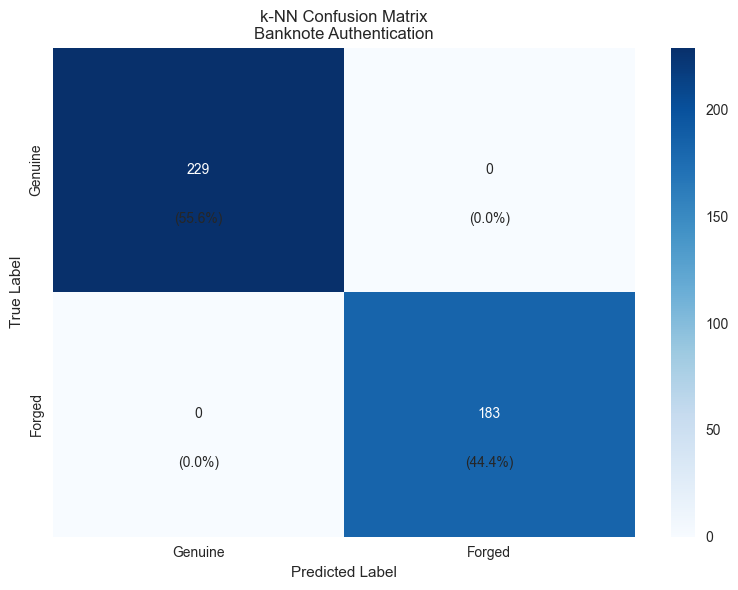


Detailed Metrics:
True Positives (Correctly identified forged): 183
True Negatives (Correctly identified genuine): 229
False Positives (Genuine labeled as forged): 0
False Negatives (Forged labeled as genuine): 0

Precision (Forged): 1.0000
Recall (Forged): 1.0000
Specificity (Genuine): 1.0000
F1-Score: 1.0000


In [25]:
# Detailed evaluation with confusion matrix
print("DETAILED CLASSIFICATION RESULTS")
print("=" * 40)

# Classification report
target_names = ['Genuine', 'Forged']
print("\nClassification Report:")
print(classification_report(y_test, sklearn_predictions, target_names=target_names))

# Confusion matrix visualization
cm = confusion_matrix(y_test, sklearn_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('k-NN Confusion Matrix\nBanknote Authentication')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add percentage annotations
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / total * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"\nDetailed Metrics:")
print(f"True Positives (Correctly identified forged): {tp}")
print(f"True Negatives (Correctly identified genuine): {tn}")
print(f"False Positives (Genuine labeled as forged): {fp}")
print(f"False Negatives (Forged labeled as genuine): {fn}")
print(f"\nPrecision (Forged): {precision:.4f}")
print(f"Recall (Forged): {recall:.4f}")
print(f"Specificity (Genuine): {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")

## Memory Usage in Lazy Learning

One important characteristic of lazy learning is memory usage - we need to store all training data!

In [26]:
import sys

print("MEMORY USAGE ANALYSIS")
print("=" * 25)

# Calculate memory usage of stored training data
X_train_memory = sys.getsizeof(X_train_scaled) + X_train_scaled.nbytes
y_train_memory = sys.getsizeof(y_train) + y_train.memory_usage(deep=True)
total_memory = X_train_memory + y_train_memory

print(f"Training data dimensions: {X_train_scaled.shape}")
print(f"Memory usage:")
print(f"  Features (X): {X_train_memory:,} bytes ({X_train_memory/1024:.1f} KB)")
print(f"  Labels (y): {y_train_memory:,} bytes ({y_train_memory/1024:.1f} KB)")
print(f"  Total: {total_memory:,} bytes ({total_memory/1024:.1f} KB)")

# Estimate for larger datasets
print("\nScaling Estimates:")
bytes_per_sample = total_memory / len(X_train_scaled)
print(f"Memory per sample: {bytes_per_sample:.1f} bytes")

for n_samples in [10000, 100000, 1000000]:
    estimated_memory = n_samples * bytes_per_sample
    if estimated_memory < 1024**2:
        print(f"  {n_samples:,} samples: {estimated_memory/1024:.1f} KB")
    elif estimated_memory < 1024**3:
        print(f"  {n_samples:,} samples: {estimated_memory/1024**2:.1f} MB")
    else:
        print(f"  {n_samples:,} samples: {estimated_memory/1024**3:.1f} GB")

print("\n💡 Memory grows linearly with training set size!")
print("   This is a key limitation of lazy learning algorithms.")

MEMORY USAGE ANALYSIS
Training data dimensions: (960, 4)
Memory usage:
  Features (X): 30,848 bytes (30.1 KB)
  Labels (y): 30,752 bytes (30.0 KB)
  Total: 61,600 bytes (60.2 KB)

Scaling Estimates:
Memory per sample: 64.2 bytes
  10,000 samples: 626.6 KB
  100,000 samples: 6.1 MB
  1,000,000 samples: 61.2 MB

💡 Memory grows linearly with training set size!
   This is a key limitation of lazy learning algorithms.


## Summary: How Lazy Learning Works

### Key Concepts We Learned:

1. **"Training" in Lazy Learning**
   - No actual learning happens
   - Just stores all training data
   - Extremely fast (microseconds)

2. **Prediction Process**
   - Calculate distances to ALL training points
   - Find k nearest neighbors
   - Majority vote for classification
   - All computation happens here

3. **Time Complexity**
   - Training: O(1) - constant time
   - Prediction: O(n×d) - linear in training size and dimensions
   - Trade-off: Fast training vs slow prediction

4. **Memory Requirements**
   - Must store entire training dataset
   - Memory grows linearly with training size
   - Can be problematic for large datasets

5. **Performance on Banknote Dataset**
   - High accuracy (~99%)
   - Clear class separation helps k-NN
   - Feature scaling was essential

### When to Use Lazy Learning:
- ✅ Small to medium datasets
- ✅ When training speed is critical
- ✅ When data distribution is unknown
- ✅ When you need interpretable decisions
- ❌ Avoid for large datasets
- ❌ Avoid when prediction speed is critical

### Next Steps:
In the next notebook, we'll explore how different distance metrics affect k-NN performance!